In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from os.path import join as pjoin
import sys
import os
import pandas as pd
import numpy as np
import json
import lightgbm as lgb
from pathlib import Path
import plotly.express as px

add_path = pjoin(os.getcwd(), '..')
add_path = Path(add_path).resolve()
sys.path.insert(0, str(add_path))

from competition_scripts.competition_utils import (
    add_features_to_skeleton, calculate_scores, 
    join_datasets, perc_mae_lgb, percentage_mae
)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load processed data

In [2]:
DATA_DIR_PROCESSED = pjoin('..', 'data', 'processed')
DATA_DIR_RAW = pjoin('..', 'data', 'raw')
df_train = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_train.parquet'))
df_test = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_test.parquet'))
df_sku = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_sku.parquet'))
df_geo = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_geo.parquet'))

with open(pjoin(DATA_DIR_PROCESSED, 'col_mapping.json'), 'r') as f:
    colmapping_dict = json.load(f)
    
# important columns
group_cols = ('sku_id', 'geo_cluster_id')
date_col = 'date'
target_col = 'sales'

### Train/val/test splits

In [3]:
val_period_pub_length = 7
val_period_pr_length = 7

train_period = [
    df_train[date_col].min(),
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length)
]
val_period_public = [
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length - 1),
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length)
]
val_period_private = [
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length - 1),
    df_train[date_col].max()
]

idx_train = (
    (df_train[date_col] >= train_period[0]) 
    & (df_train[date_col] <= train_period[1])
)

idx_train_last_month = (
    (df_train[date_col] >= train_period[1] - pd.Timedelta(days=28)) 
    & (df_train[date_col] <= train_period[1])
)

idx_train_last_month_for_correction = (
    (df_train[date_col] >= val_period_private[1] - pd.Timedelta(days=30)) 
    & (df_train[date_col] <= val_period_private[1])
)

idx_val = (
    (df_train[date_col] >= val_period_public[0]) 
    & (df_train[date_col] <= val_period_public[1])
)
idx_test = (
    (df_train[date_col] >= val_period_private[0]) 
    & (df_train[date_col] <= val_period_private[1])
)

assert (idx_test | idx_train | idx_val).mean() == 1.

### Additional features

In [4]:
# https://pypi.org/project/holidays/
# !pip install holidays
import holidays

ua_holidays = holidays.UKR()
dates = sorted(set(
    df_train['date'].unique().tolist() + df_test['date'].unique().tolist()
))

holidays = []
for d in dates:
    holidays.append(int(d / 10**9) in ua_holidays)
    
is_holiday = dict(zip(dates, holidays))

df_train['is_holiday'] = df_train['date'].astype(np.int64).map(is_holiday)
df_test['is_holiday'] = df_test['date'].astype(np.int64).map(is_holiday)

In [5]:
# !pip install gensim
# nlp features
from gensim.models import Word2Vec

replace_regex = '[\s—,/]+'
sentences = (
    df_sku.title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.product_type_title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.commodity_group_title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.origin_country.str.lower().str.replace(replace_regex, ' ', regex=True)
)

sentences_series = sentences.str.replace('[0-9\.]+', '')
sentences_series = sentences_series[sentences_series.notnull()]

max_len = int(sentences_series.str.split('\s+').str.len().max())
print(max_len)
sentences = sentences_series.str.split('\s+').tolist()
sentences = [[w for w in s if len(w) > 1] for s in sentences]
sentences = [s for s in sentences if s]

w2v = Word2Vec(
    sentences=sentences,
    vector_size=8,
    window=max_len,
    min_count=1,
    batch_words=500,
    sg=0,
)

vocab = w2v.wv.key_to_index
print(f'words in vocab: {len(vocab)}')

print(w2v.wv.most_similar('banana', topn=7))

# build sku-level embeddings, simple averaging
sku_embs = {
    sku: np.zeros(w2v.vector_size)
    for sku in df_sku.index.tolist()
}
for i, s in sentences_series.items():
    tokens = s.split(' ')
    emb = np.zeros(w2v.vector_size)
    cnt = 0
    for t in tokens:
        if t in w2v.wv:
            emb += w2v.wv[t]
            cnt += 1
    if cnt != 0:
        emb /= cnt
    sku_embs[i] = emb
    
sku_embs = pd.DataFrame(sku_embs).T.astype(np.float32)
sku_embs.columns = [f'w2v_emb_{i+1}' for i in range(len(sku_embs.columns))]
sku_embs.index.name = 'sku_id'
sku_embs

16
words in vocab: 263
[('grapefruit', 0.9853621125221252), ('citrus', 0.9783074259757996), ('como', 0.9778860807418823), ('confectionary', 0.9756187796592712), ('orange', 0.9690552949905396), ('pineapple', 0.9665234088897705), ('alma', 0.9653270840644836)]


,w2v_emb_1,w2v_emb_2,w2v_emb_3,w2v_emb_4,w2v_emb_5,w2v_emb_6,w2v_emb_7,w2v_emb_8
sku_id,,,,,,,,
17,-0.613400,0.368053,-0.634122,0.005915,1.693699,0.005733,0.982584,-0.281478
18,-0.586724,0.400572,-0.590650,-0.046997,1.767318,-0.038265,0.922868,-0.100942
24,-0.629215,0.420973,-0.613216,0.025009,1.732937,-0.019977,0.995371,-0.262781
25,-0.586287,0.306531,-0.660516,0.026975,1.584505,-0.098628,0.995551,-0.196404
208,0.665920,0.657977,-0.096269,-1.337203,2.158585,-0.638259,0.331346,-1.494282
...,...,...,...,...,...,...,...,...
873803,-0.342109,0.669412,0.246947,-0.243078,1.171487,-0.181959,0.598105,-0.322623
873804,-0.317623,0.764013,0.438810,-0.085553,1.303396,-0.221918,0.642721,-0.156087
873805,-0.317623,0.764013,0.438810,-0.085553,1.303396,-0.221918,0.642721,-0.156087


In [6]:
# merge embeddings with dfs
df_train = df_train.reset_index().merge(
    sku_embs.reset_index(),
    how='left',
    on='sku_id',
)

df_test = df_test.merge(
    sku_embs.reset_index(),
    how='left',
    on='sku_id',
)

In [7]:
df_train[f'{target_col}_14d'] = df_train.groupby(
    list(group_cols)
)[target_col].shift(14).fillna(0).astype(np.float32)

df_train[f'{target_col}_28d'] = df_train.groupby(
    list(group_cols)
)[target_col].shift(28).fillna(0).astype(np.float32)

windows = [7, 14, 28]

for w in windows:
    df_train[f'{target_col}_rolling_{w}_median'] = \
    df_train.groupby(list(group_cols))[f'{target_col}_14d']\
    .rolling(window=w, min_periods=1).median().values.astype(np.float32)
    
#     df_train[f'{target_col}_rolling_{w}_mean'] = \
#     df_train.groupby(list(group_cols))[f'{target_col}_14d']\
#     .rolling(window=w, min_periods=1).mean().values.astype(np.float32)
#     df_train[f'{target_col}_rolling_{w}_max'] = \
#     df_train.groupby(list(group_cols))[f'{target_col}_14d']\
#     .rolling(window=w, min_periods=1).max().values.astype(np.float32)
#     df_train[f'{target_col}_rolling_{w}_std'] = \
#     df_train.groupby(list(group_cols))[f'{target_col}_14d']\
#     .rolling(window=w, min_periods=1).std().values.astype(np.float32)
    
# df_train.drop(columns=[f'{target_col}_14d'], inplace=True)
    
df_train.filter(regex=f'{target_col}').corr()

,sales,sales_14d,sales_28d,sales_rolling_7_median,sales_rolling_14_median,sales_rolling_28_median
sales,1.000000,0.376132,0.354301,0.502741,0.520363,0.516087
sales_14d,0.376132,1.000000,0.375114,0.612380,0.586511,0.560763
sales_28d,0.354301,0.375114,1.000000,0.518112,0.558210,0.584483
sales_rolling_7_median,0.502741,0.612380,0.518112,1.000000,0.921020,0.872855
sales_rolling_14_median,0.520363,0.586511,0.558210,0.921020,1.000000,0.948563
sales_rolling_28_median,0.516087,0.560763,0.584483,0.872855,0.948563,1.000000


In [ ]:
## calculate same features for test
df_test_extended = pd.concat(
    [
        df_train.loc[idx_train_last_month.values, :].copy().set_index('transaction_id'),
        df_test.copy().set_index('transaction_id')
    ])

df_test_extended = df_test_extended.sort_values(
    by=['sku_id', 'geo_cluster_id', date_col]
)

df_test_extended[f'{target_col}_14d'] = df_test_extended.groupby(
    list(group_cols)
)[target_col].shift(14).fillna(0).astype(np.float32)

df_test_extended[f'{target_col}_28d'] = df_test_extended.groupby(
    list(group_cols)
)[target_col].shift(28).fillna(0).astype(np.float32)

windows = [7, 14, 28]

for w in windows:
    df_test_extended[f'{target_col}_rolling_{w}_median'] = \
    df_test_extended.groupby(list(group_cols))[f'{target_col}_14d']\
    .rolling(window=w, min_periods=1).median().values.astype(np.float32)
    
# move back to df test
df_test = df_test_extended.reindex(df_test['transaction_id'])

In [24]:
# check baseline
grouping = ['sku_id', 'geo_cluster_id']
baseline_dict = df_train[idx_train_last_month].groupby(grouping)[target_col].median()

pred_baseline_val = \
df_train[idx_val].set_index(grouping).index.map(baseline_dict).fillna(0).values
pred_baseline_test = \
df_train[idx_test].set_index(grouping).index.map(baseline_dict).fillna(0).values

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
print('median baseline')
baseline_score_pub, baseline_score_pr = calculate_scores(
    df=df_train,
    idx_val=idx_val,
    idx_test=idx_test,
    pred_val=pred_baseline_val,
    pred_test=pred_baseline_test,
    grouping_col=date_col,
    target_col=target_col
)

### LGB datasets

In [30]:
categorical_feature = [
    'geo_cluster_id',
#     'sku_id',
    'city_id',
    'category_id', 
    'product_type_id', 
    'brand_id', 
    'trademark_id',
    'origin_country_id', 
    'commodity_group_id', 
#     'weekday', 
#     'week_no',
    'month',
]

cols_to_drop = [
    date_col,
    'price_change_perc', # leak, assumption, when diff is null, target == 0 ?
    'price_change_logdiff', # leak, assumption, when diff is null, target == 0 ?
    target_col,
    'transaction_id',
]

In [31]:
features = df_train[idx_train.values].drop(
    columns=[target_col] + cols_to_drop).columns.tolist()
assert set(categorical_feature).issubset(set(features))

# new_idx_train = idx_train.copy()
new_idx_train = (idx_train & df_train[target_col] > 0).copy()

ds_tr = lgb.Dataset(
    data=df_train.loc[
        idx_train.values,
#         new_idx_train,  # check metric change
        features
    ],
    label=df_train.loc[
        idx_train.values, 
#         new_idx_train,
        target_col
    ],
#     weight=np.log1p(df_train.loc[idx_train, target_col]),
    categorical_feature=categorical_feature,
    free_raw_data=False,
)

ds_val = lgb.Dataset(
    data=df_train.loc[idx_val.values, features],
    label=df_train.loc[idx_val.values, target_col],
#     weight=np.log1p(df_train.loc[idx_val, target_col]),
    categorical_feature=categorical_feature,
    reference=ds_tr,
    free_raw_data=False,
)

ds_tr.grouping_ = df_train.loc[idx_train.values, date_col].copy()
ds_val.grouping_ = df_train.loc[idx_val.values, date_col].copy()

In [32]:
lgb_params = {
    'early_stopping_round': 25,
    'num_iterations': 100,
#     'objective': 'tweedie', # ?
    'objective': 'mae',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 127,
    'seed': 42,
    'deterministic': True,
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'feature_fraction': 1.,
    'max_cat_to_onehot': 10,
    'cat_l2': 2.,
    'cat_smooth': 1.,
    'verbosity': 1,
}

In [33]:
model = lgb.train(
    params=lgb_params,
    train_set=ds_tr,
    feval=perc_mae_lgb(),
    valid_sets=[
#         ds_tr, 
        ds_val
    ],
    valid_names=[
#         'train_all', 
        'val_public'
    ],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.606249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4114
[LightGBM] [Info] Number of data points in the train set: 26356037, number of used features: 27
[1]	val_public's l1: 0.185226	val_public's perc_mae: 0.993616
Training until validation scores don't improve for 25 rounds
[2]	val_public's l1: 0.184083	val_public's perc_mae: 0.987474
[3]	val_public's l1: 0.183044	val_public's perc_mae: 0.981884
[4]	val_public's l1: 0.18198	val_public's perc_mae: 0.976168
[5]	val_public's l1: 0.181004	val_public's perc_mae: 0.970915
[6]	val_public's l1: 0.180095	val_public's perc_mae: 0.96603
[7]	val_public's l1: 0.179284	val_public's perc_mae: 0.961676
[8]	val_public's l1: 0.178478	val_public's perc_mae: 0.957337
[9]	val_public's l1: 0.177762	val_public's perc_mae: 0.953493
[10]	val_public's l1: 0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

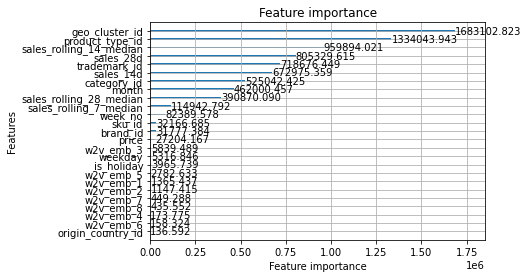

In [34]:
# check learned importances
lgb.plot_importance(model, importance_type='gain')

In [37]:
ml_pred_test = model.predict(
    data=df_train.loc[idx_test.values, features]
)

ml_pred_val = model.predict(
    data=df_train.loc[idx_val.values, features]
)

print('ML baseline')
ml_score_pub, ml_score_pr = calculate_scores(
    df=df_train,
    idx_val=idx_val.values,
    idx_test=idx_test.values,
    pred_val=ml_pred_val,
    pred_test=ml_pred_test,
    grouping_col=date_col,
    target_col=target_col
)

print('zero % in predictions')
(ml_pred_val == 0).mean(), (ml_pred_test == 0).mean()

ML baseline
public : 0.90721
private: 0.90557

zero % in predictions


(0.9706006344987623, 0.9710734519369791)

In [54]:
def metric(groups, target, predict):
    df = groups.copy()
    df['target'] = target
    df['predict'] = predict
    df['mae'] = (df['target'] - df['predict']).abs()
    
    mae_sum = df.groupby(['geo_cluster_id', 'sku_id'])['mae'].sum()
    target_sum = df.groupby(['geo_cluster_id', 'sku_id'])['target'].sum()
    
    mask = target_sum > 0
    mae_sum = mae_sum[mask]
    target_sum = target_sum[mask]

    return (mae_sum/target_sum).mean()

gr = df_train.loc[idx_val.values, [date_col] + list(group_cols)].copy()

for d in gr[date_col].unique():
    idx_d = gr[date_col] == d
    x = []
    x.append(
        metric(
            gr[idx_d], 
            df_train.loc[idx_val.values, target_col].values[idx_d],
            ml_pred_val[idx_d], 
        )
    )
    
np.array(x).mean()

0.9307980489093426

### Make submission

In [38]:
ml_pred_sub = model.predict(
    data=df_test.loc[:, features]
)

In [39]:
ml_pred_sub = np.clip(ml_pred_sub, 0, np.inf)
ml_pred_sub.min(), ml_pred_sub.mean(), ml_pred_sub.max()

(0.0, 0.03274158069038727, 29.536505322067754)

In [40]:
# load sample submission
SUBMISSION_DIR = pjoin('..', 'submissions')

subm = pd.read_csv(pjoin(DATA_DIR_RAW, 'sample_final.csv'))
subm['sales'] = ml_pred_sub
subm['sales'] = subm['sales'].fillna(0.)

score_pub = str(round(ml_score_pub, 5)).replace('.', '_')
score_pr = str(round(ml_score_pr, 5)).replace('.', '_')
subm_name = f'baseline_lgb_no_price_leak={score_pub}_pr={score_pr}.csv'
subm.to_csv(
    pjoin(SUBMISSION_DIR, subm_name),
    index=False
)

print(subm_name)

baseline_lgb_no_price_leak=0_90721_pr=0_90557.csv
